In [1]:
import boto3
import pandas

s3 = boto3.client('s3')
bucket = 'gaming-analytics'
prefix = 'gamelog/gamelog_sagemaker/'
response = s3.list_objects_v2(Bucket = bucket, Prefix = prefix)

objs = []

for obj in response['Contents']:
    objs.append(obj['Key'])

game_data = pandas.concat([pandas.read_csv('s3://' + bucket + '/' + obj, delimiter = ',') for obj in objs])

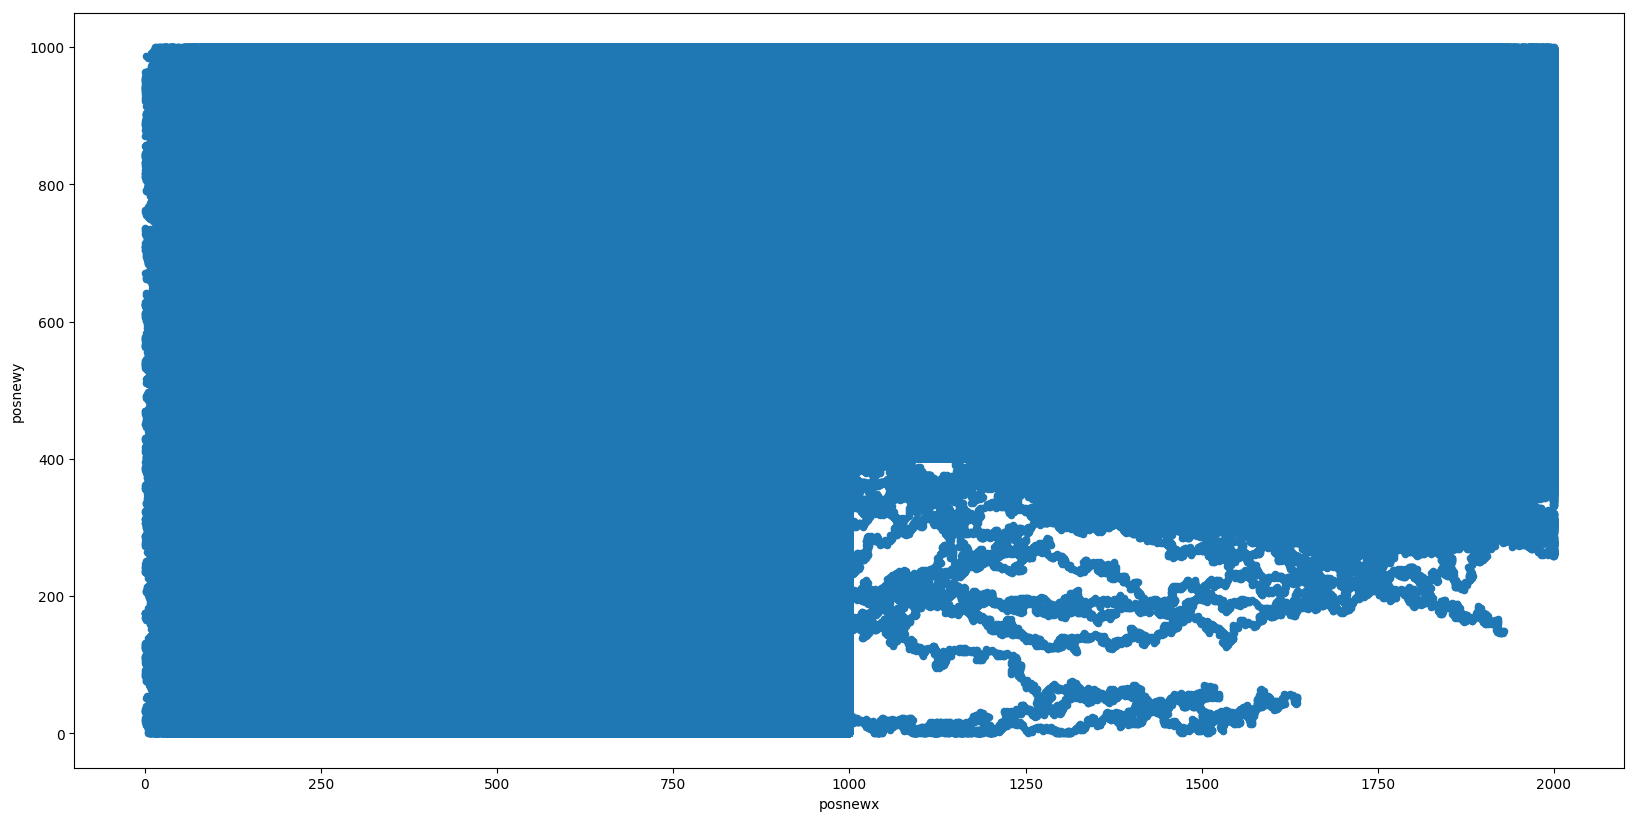

In [3]:
import matplotlib

matplotlib.rcParams['agg.path.chunksize'] = 100000
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['figure.dpi'] = 100

game_data.plot.scatter(
    x = 'posnewx',
    y = 'posnewy'
)

In [4]:
def convert_and_upload_training_data(
    ndarray, bucket, prefix, filename='gamelog.pbr'):
    import boto3
    import os
    from sagemaker.amazon.common import numpy_to_record_serializer

    # Convert Numpy array to Protobuf RecordIO format
    serializer = numpy_to_record_serializer()
    buffer = serializer(ndarray)

    # Upload to S3
    s3_object = os.path.join(prefix, 'train', filename)
    boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(buffer)
    s3_path = 's3://{}/{}'.format(bucket, s3_object)
    return s3_path

bucket = 'gaming-analytics'
prefix = 'sagemaker/randomcutforest'
s3_train_data = convert_and_upload_training_data(
    game_data.as_matrix().reshape(-1,2),
    bucket,
    prefix)

In [19]:
import boto3
import sagemaker

containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/randomcutforest:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/randomcutforest:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/randomcutforest:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/randomcutforest:latest'}
region_name = boto3.Session().region_name
container = containers[region_name]

session = sagemaker.Session()

# Set training job parameter
rcf = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.p3.8xlarge',
    sagemaker_session=session)

# Set RCF Hyperparameter
rcf.set_hyperparameters(
    num_samples_per_tree=1000,
    num_trees=200,
    feature_dim=2)

s3_train_input = sagemaker.session.s3_input(
    s3_train_data,
    distribution='ShardedByS3Key',
    content_type='application/x-recordio-protobuf')

rcf.fit({'train': s3_train_input})

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-01-22-07-17-35-212


2019-01-22 07:17:35 Starting - Starting the training job...
2019-01-22 07:17:38 Starting - Launching requested ML instances.........
2019-01-22 07:19:10 Starting - Preparing the instances for training......
2019-01-22 07:20:31 Downloading - Downloading input data...
2019-01-22 07:21:00 Training - Downloading the training image...
2019-01-22 07:21:17 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[01/22/2019 07:21:20 INFO 140613227358016] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[01/22/2019 07:21:20 INFO 140613227358016

In [20]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=2,
    instance_type='ml.p3.8xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.deserializer = json_deserializer

INFO:sagemaker:Creating model with name: randomcutforest-2019-01-22-07-23-09-821
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-01-22-07-17-35-212


--------------------------------------------------------------------------------------!

In [ ]:
#In Demo, start from below

In [50]:
import pandas
import urllib.request

predict_file = 'predict.csv'
predict_source = 'https://s3.amazonaws.com/anhyobin-gaming/predict.csv'

urllib.request.urlretrieve(predict_source, predict_file)
predict_data = pandas.read_csv(predict_file, delimiter = ',')

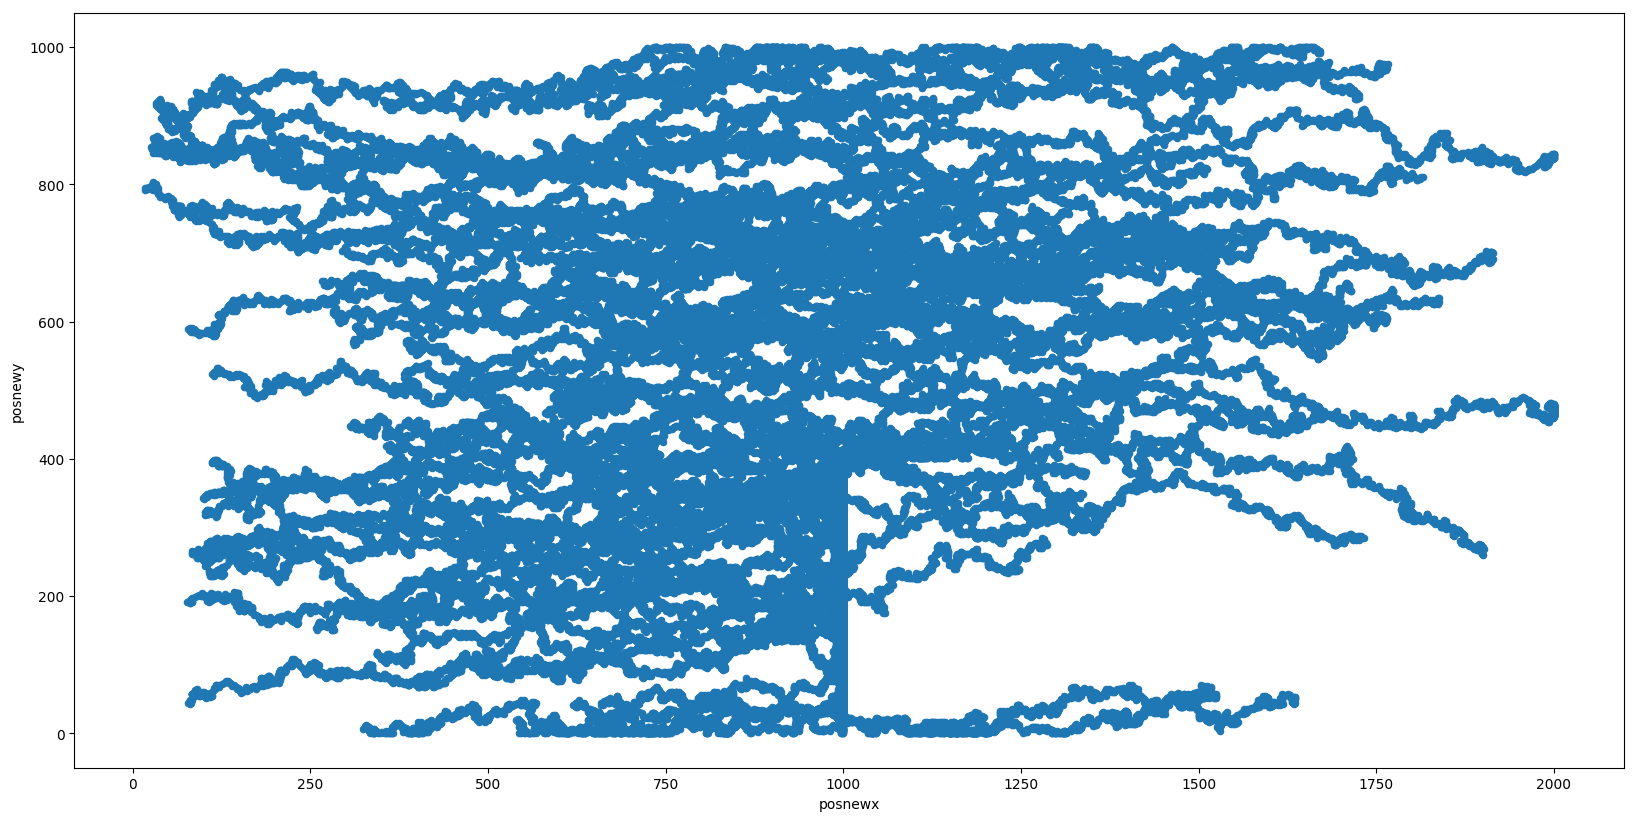

In [51]:
import matplotlib

matplotlib.rcParams['agg.path.chunksize'] = 100000
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['figure.dpi'] = 100

predict_data.plot.scatter(
    x = 'posnewx',
    y = 'posnewy'
)

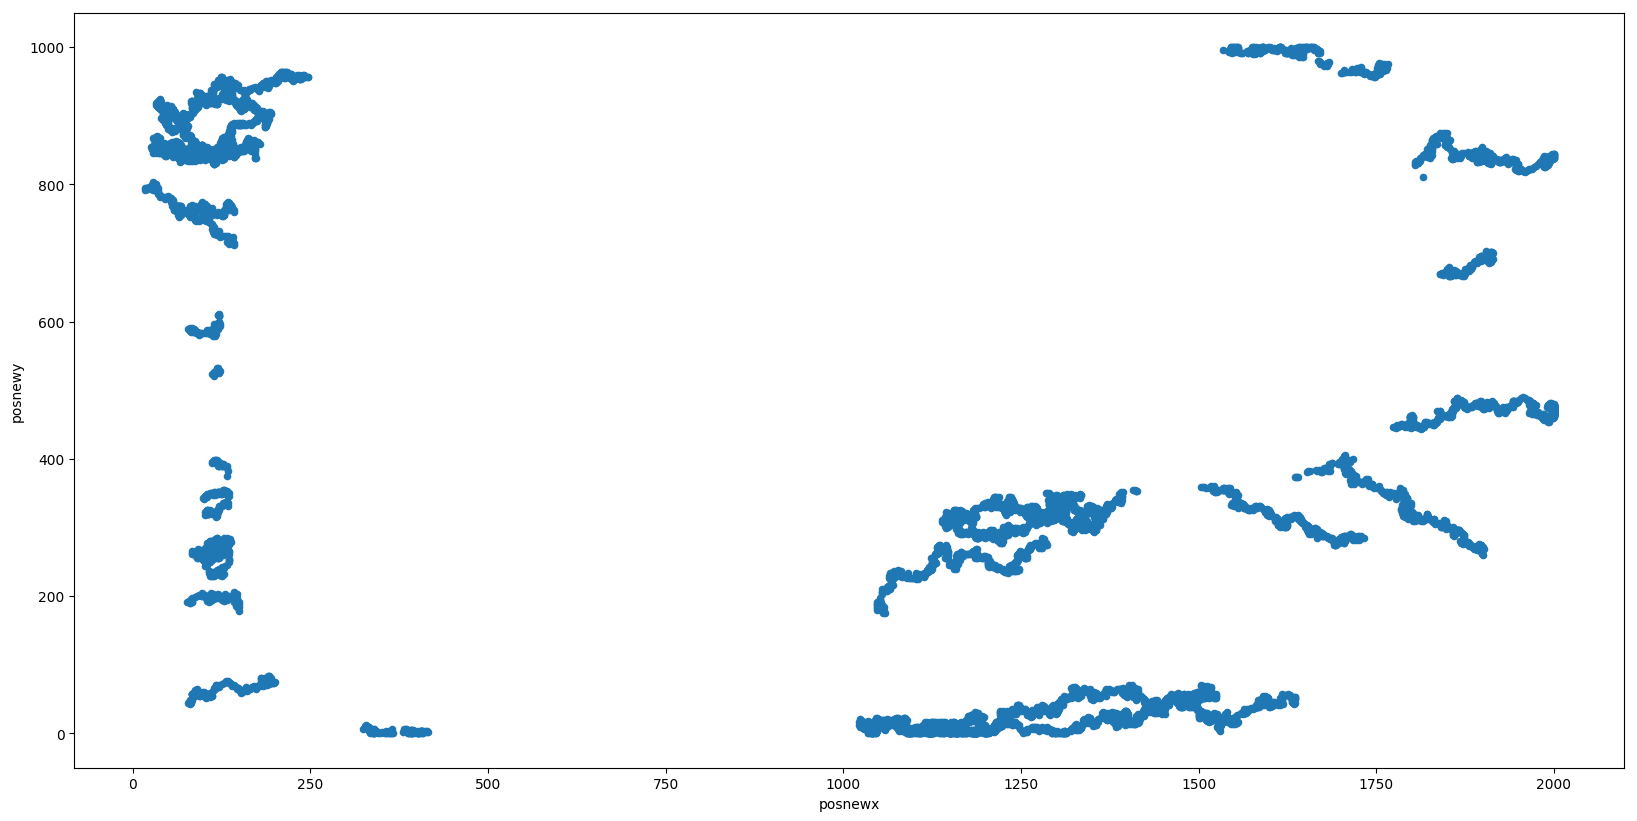

In [52]:
results = rcf_inference.predict(predict_data.as_matrix().reshape(-1,2))
scores = [datum['score'] for datum in results['scores']]
predict_data['score'] = pandas.Series(scores, index=predict_data.index)

score_mean = predict_data.score.mean()
score_std = predict_data.score.std()
score_cutoff = score_mean + 1.5 * score_std

anomalies = predict_data[predict_data['score'] > score_cutoff]

anomalies.plot.scatter(
    x = 'posnewx',
    y = 'posnewy'
)